# Analyze A/B Test Results 

This project will assure you have mastered the subjects covered in the statistics lessons. We have organized the current notebook into the following sections: 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final Check](#finalcheck)
- [Submission](#submission)

Specific programming tasks are marked with a **ToDo** tag. 

<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.

Each **ToDo** task below has an associated quiz present in the classroom.  Though the classroom quizzes are **not necessary** to complete the project, they help ensure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the [rubric](https://review.udacity.com/#!/rubrics/1214/view) specification. 

<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [1]:
# import packages
import pandas as pd
import numpy as np
import statsmodels.api as sm
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### ToDo 1.1
Now, read in the `ab_data.csv` data. Store it in `df`. Below is the description of the data, there are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>

**a.** Read in the dataset from the `ab_data.csv` file and take a look at the top few rows here:

In [2]:
#read data and print heads and info
df = pd.read_csv('ab_data.csv')
print(df.head())
print(df.info())

   user_id                   timestamp      group landing_page  converted
0   851104  2017-01-21 22:11:48.556739    control     old_page          0
1   804228  2017-01-12 08:01:45.159739    control     old_page          0
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0
3   853541  2017-01-08 18:28:03.143765  treatment     new_page          0
4   864975  2017-01-21 01:52:26.210827    control     old_page          1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB
None


**b.** Use the cell below to find the number of rows in the dataset.

In [3]:
total = df.shape[0]
print('Number of rows in the dataset = ', total)

Number of rows in the dataset =  294478


**c.** The number of unique users in the dataset.

In [4]:
id_unq = df.user_id.nunique()
print('Number of of unique users in the dataset = ', id_unq)

Number of of unique users in the dataset =  290584


In [5]:
print('Number of of non-unique user rows in the dataset = ', total - id_unq)
print('Percent of of non-unique user rows in the dataset = ', (total - id_unq)/total)

Number of of non-unique user rows in the dataset =  3894
Percent of of non-unique user rows in the dataset =  0.013223398691922657


**d.** The proportion of users converted.

In [6]:
p_conv = df.converted.mean()
print('The proportion of users converted = ', p_conv)

The proportion of users converted =  0.119659193556


**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [7]:
trtmt_oldpage = df.query('group == "treatment" and landing_page == "old_page"').user_id.count()
print('Number of times when the group = treatment but landing_page != new_page \n', trtmt_oldpage)

Number of times when the group = treatment but landing_page != new_page 
 1965


In [8]:
trtmt = df.query('group == "treatment"').user_id.count()
print('Size of treatment group =', trtmt)
print('% of mistakes =', trtmt_oldpage/trtmt)

Size of treatment group = 147276
% of mistakes = 0.0133422960971


In [9]:
ctrl_newpage = df.query('group == "control" and landing_page == "new_page"').user_id.count()
print('Number of times when the group != treatment but landing_page = new_page \n', ctrl_newpage)

Number of times when the group != treatment but landing_page = new_page 
 1928


In [10]:
ctrl = df.query('group != "treatment"').user_id.count()
print('Size of control group =', ctrl)
print('% of mistakes =', ctrl_newpage/ctrl)

Size of control group = 147202
% of mistakes = 0.0130976481298


In [11]:
print('Total quantity of mismatches =', trtmt_oldpage +  ctrl_newpage)
print('Total % of mistakes =', (trtmt_oldpage +  ctrl_newpage)/total)

Total quantity of mismatches = 3893
Total % of mistakes = 0.0132200028525


**f.** Do any of the rows have missing values?

In [12]:
null_row_q = df.isnull().sum()
print ('Quantity of rows witn NULL values \n', null_row_q)

Quantity of rows witn NULL values 
 user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64


**Conclusion:** 

- overall amount of records is significant = 294478
- dataframe does not contain missing value
- 'timestamp' has 'object' type instead of 'datetime' (probably needs to be converted later)
- total mismatches between 'group' and 'landing_page' is 3893 records, % of mismatches 1.3%

Total % of mismatches is not significant and might be dropped with out big impact on curretnt test precision. <br>
For future tests needs to make investigation about reasons of mismatches, to make test more accurate. <br>



### ToDo 1.2  
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  

**a.** Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [13]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
#select all treatment and new page rows
df2 = df.query('group == "treatment" and landing_page == "new_page"')
print('Size of first part of dataframe =', df2.shape)

#select all control and old page rows and append to df2
df2 = df2.append(df.query('group == "control" and landing_page == "old_page"'))
print('Total size of dataframe = ', df2.shape)

Size of first part of dataframe = (145311, 5)
Total size of dataframe =  (290585, 5)


In [14]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

**Conclusion:**

 - new dataframe does not contain mismatches
 - total amount of records is 290585 (same as in section 'c')

### ToDo 1.3  

**a.** How many unique **user_id**s are in **df2**?

In [15]:
total2 = df2.shape[0]
print('Number of rows in the dataset = ', total2)

Number of rows in the dataset =  290585


In [16]:
id_unq2 = df2.user_id.nunique()
print('Number of of unique users in the dataset = ', id_unq2)

Number of of unique users in the dataset =  290584


In [17]:
print('Number of of non-unique user rows in the dataset = ',  total2 - id_unq2)
print('Percent of of non-unique user rows in the dataset = ', (total2 - id_unq2)/total2)

Number of of non-unique user rows in the dataset =  1
Percent of of non-unique user rows in the dataset =  3.441333861004525e-06


**b.** There is one **user_id** repeated in **df2**.  What is it?

In [18]:
#select index of duplicated records in column 'user_id'
user_id_dup_idx = df2.user_id.duplicated()
# select duplicated 'user_id' list
user_id_dup = df2[user_id_dup_idx].user_id.values
print('user_id  witn duplicated records =', user_id_dup);

user_id  witn duplicated records = [773192]


**c.** Display the rows for the duplicate **user_id**? 

In [19]:
# get and print all data for duplicated 'user_is'
print('Rows with duplicated user_id value: \n', df2.query('user_id == @user_id_dup'))

Rows with duplicated user_id value: 
       user_id                   timestamp      group landing_page  converted
1899   773192  2017-01-09 05:37:58.781806  treatment     new_page          0
2893   773192  2017-01-14 02:55:59.590927  treatment     new_page          0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [20]:
# Get duplicated index and remove one of the rows with a duplicate user_id..
drop_idx = df2[user_id_dup_idx].index
df2.drop( index=drop_idx, inplace=True)

# Check again if the row with a duplicate user_id is deleted or not
total2 = df2.shape[0]
id_unq2 = df2.user_id.nunique()
print('Number of rows in the dataset = ', total2)
print('Number of of non-unique user rows in the dataset = ',  total2 - id_unq2);

Number of rows in the dataset =  290584
Number of of non-unique user rows in the dataset =  0


In [21]:
# save clean data in file 'ab_data_clean.csv'
df2.to_csv('ab_data_clean.csv', index=False)

**Conclusion:**

   - only one duplicate user ID found 
   - user_id = 773192
   - group = treatment
   - landing_page = new_page
   - converted = False
   - after duplicated droping final amount of records is 290584 (one less)

### ToDo 1.4  
**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>



In [22]:
#check if dataframe 'df2' was loaded before
if 'df2' not in globals():
    # if start without cleaning - load ab data clean 
    df2 = pd.read_csv('ab_data_clean.csv')
    total2 = df2.shape[0]
    print(df2.head(3))
else:
    print('Data frame "df2" exist.')

Data frame "df2" exist.


In [23]:
p_pop = df2.converted.mean()
print('Population probability of converted success', p_pop)

Population probability of converted success 0.119597087245


**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [24]:
p_cn = df2.query('group == "control"').converted.mean()
print('Population probability of converted success', p_cn)

Population probability of converted success 0.1203863045


**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [25]:
p_tr = df2.query('group == "treatment"').converted.mean()
print('Population probability of converted success', p_tr)

Population probability of converted success 0.118808065515


Calculate the actual difference  (`obs_diff`) between the conversion rates for the two groups. You will need that later.  

In [26]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = p_tr - p_cn
print('Actual difference between the conversion rates for the two groups =', obs_diff)
print('% of difference between the conversion rates for the two groups =', obs_diff/p_tr)

Actual difference between the conversion rates for the two groups = -0.00157823898536
% of difference between the conversion rates for the two groups = -0.013283938077


**d.** What is the probability that an individual received the new page?

In [27]:
p_new = df2.query('landing_page  == "new_page"').landing_page.count()/total2
print('Probability that an individual received the new page = ',p_new)

Probability that an individual received the new page =  0.500061944223


**e.** Consider your results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.

**Conclusion:**
    
   - avarage probability of of conversions success is not so big 11.96%
   - users from from 'treatment' group give less conversions success over 'control' group
   - difference is 1,33% and looks like not so significant

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


### ToDo 2.1
For now, consider you need to make the decision just based on all the data provided.  

Recall that you just calculated that the "converted" probability (or rate) for the old page is *slightly* higher than that of the new page (ToDo 1.4.c). 

If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be your null and alternative hypotheses (**$H_0$** and **$H_1$**)?  

You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the "converted" probability (or rate) for the old and new pages respectively.

$$H_0: p_{new} - p_{old} \leq 0$$

$$H_1: p_{new} - p_{old} > 0 $$

### ToDo 2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, you will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 

In [28]:
p_pop = df2.converted.mean()
print('Population probability of converted success =', p_pop)

Population probability of converted success = 0.119597087245


**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [29]:
p_new = p_pop
print('Conversion rate for  𝑝_𝑛𝑒𝑤  under the null hypothesis =', p_new)

Conversion rate for  𝑝_𝑛𝑒𝑤  under the null hypothesis = 0.119597087245


**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [30]:
p_old = p_pop
print('Conversion rate for  𝑝_𝑜𝑙𝑑  under the null hypothesis = ', p_old)

Conversion rate for  𝑝_𝑜𝑙𝑑  under the null hypothesis =  0.119597087245


**c.** What is $n_{new}$, the number of individuals in the treatment group?


In [31]:
df_tr = df2.query('landing_page  == "new_page"')
n_new = df_tr.shape[0]
print('Number of individuals in the treatment group = ', n_new)

Number of individuals in the treatment group =  145310


**d.** What is $n_{old}$, the number of individuals in the control group?

In [32]:
df_cn = df2.query('landing_page  == "old_page"')
n_old = df_cn.shape[0]
print('Number of individuals in the control group = ', n_old)

Number of individuals in the control group =  145274


**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br>
Use `numpy.random.choice()` method to randomly generate $n_{new}$ number of values. <br>
Store these $n_{new}$ 1's and 0's in the `new_page_converted` numpy array.


In [33]:
# Simulate a Sample for the treatment Group
param_p_new = [1-p_new, p_new]
new_page_converted = np.random.choice(2, size=n_new, p=param_p_new)

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [34]:
# Simulate a Sample for the control Group
param_p_old = [1-p_old, p_old]
old_page_converted = np.random.choice(2, size=n_old, p=param_p_old)

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [35]:
est_p_new = new_page_converted.mean()
print('Estimated converted probability for new page =', est_p_new)

est_p_old = old_page_converted.mean()
print('Estimated converted probability for old page =', est_p_old)

est_dif = est_p_new - est_p_old
print('Estimated difference in converted probabilities =', est_dif)

Estimated converted probability for new page = 0.119496249398
Estimated converted probability for old page = 0.120331236147
Estimated difference in converted probabilities = -0.000834986749028



**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [36]:
# Sampling distribution through 'for'
#bs_p_new = []
#bs_p_old = []
#for n in range(smpl_size):
#    bs_new_page_converted = np.random.choice(2, size=n_new, p=param_p_new)
#    bs_old_page_converted = np.random.choice(2, size=n_old, p=param_p_old)
#    bs_p_new = np.append(bs_p_new, bs_new_page_converted.mean())
#    bs_p_old = np.append(bs_p_old, bs_old_page_converted.mean())

# more faster variant
new_page_converted = np.random.binomial(n_new, p_new, 10000)/n_new
old_page_converted = np.random.binomial(n_old, p_old, 10000)/n_old

p_diffs =  new_page_converted - old_page_converted    

**i. Histogram**<br> 
Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.<br>
Also, use `plt.axvline()` method to mark the actual difference observed  in the `df2` data (recall `obs_diff`), in the chart.  

Text(0,0.5,'Amount of cases')

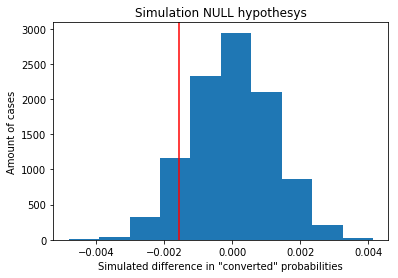

In [37]:
plt.hist(p_diffs);
# one side test: left-tailed
plt.axvline(x=obs_diff, color='r');
plt.title('Simulation NULL hypothesys')
plt.xlabel('Simulated difference in "converted" probabilities')
plt.ylabel('Amount of cases')

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [38]:
#calculate proportion of the p_diffs are greater than the actual difference
#delta = np.abs(obs_diff)
#p_val = (p_diffs > delta).mean() + (p_diffs < -delta).mean()

# one side test: left-tailed
p_val = (p_diffs > obs_diff).mean() 
print('Proportion of the p_diffs are greater than the actual difference =', p_val)

Proportion of the p_diffs are greater than the actual difference = 0.9066


**k.** Please explain in words what you have just computed in part **j** above.  
 - What is this value called in scientific studies?  
 - What does this value signify in terms of whether or not there is a difference between the new and old pages? 
 - Compare the value above with the "Type I error rate (0.05)". 

**Conclusion:**

1. We did simulation of NULL hypothesys $H_0: p_{new}-p_{old} \leq 0$ <br>
2. Matched with real difference value obs diff <br>
3. Take mean for all values more than obs_diff to test $H_0$ <br>
4. Result is probability of null hypothesys <br>
5. As soon as p_val >> 'type I error rate' we definitevly fail to reject $H_0$ hypothesys <br>
It means that $p_{new} \leq p_{old}$.



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [39]:
#check if dataframe 'df2' was loaded before
if 'df2' not in globals():
    # if start without cleaning - load ab data clean 
    df2 = pd.read_csv('ab_data_clean.csv')
    total2 = df2.shape[0]
    print(df2.head(3))
    #set means for NULL hypothesys 
    p_pop = df2.converted.mean()
    p_old = p_pop
    p_new = p_pop    
else:
    print('Data frame "df2" exist.')

Data frame "df2" exist.


In [40]:
# number of conversions with the old_page
convert_old = df2.query('landing_page  == "old_page"').converted.sum()
print('Number of conversions with the old_page = ', convert_old)

# number of conversions with the new_page
convert_new = df2.query('landing_page  == "new_page"').converted.sum()
print('Number of conversions with the new_page = ', convert_new)

# number of individuals who were shown the old_page
n_old = df2.query('group == "control"').user_id.count()
print('Number of individuals who were shown the old_page = ', n_old)

# number of individuals who received new_page
n_new = df2.query('group == "treatment"').user_id.count()
print('Number of individuals who were shown the new_page = ', n_new)

Number of conversions with the old_page =  17489
Number of conversions with the new_page =  17264
Number of individuals who were shown the old_page =  145274
Number of individuals who were shown the new_page =  145310


**m.** Now use `sm.stats.proportions_ztest()` to compute your test statistic and p-value. 

The syntax is: 
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```
where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. 
The built-in function above will return the z_score, p_value. 

---
### About the two-sample z-test
Recall that you have plotted a distribution `p_diffs` representing the
difference in the "converted" probability  $(p{'}_{new}-p{'}_{old})$  for your two simulated samples 10,000 times. 

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. You can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. You can determine the $Z_{\alpha}$ from the z-table manually. 

Decide if your hypothesis is either a two-tailed, left-tailed, or right-tailed test. Accordingly, reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. We determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. In other words, a "rejection region" is an interval where the null hypothesis is rejected iff the $Z_{score}$ lies in that region.


In [41]:
import statsmodels.api as sm
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
cnt_arr = [convert_new, convert_old]
nob_arr = [n_new, n_old,]
mean_val_dif = p_new - p_old

z_score, p_value = sm.stats.proportions_ztest(cnt_arr, nob_arr, value = mean_val_dif, alternative='larger')
print(z_score, p_value)

-1.31092419842 0.905058312759


**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br><br>

**Conclusion:**

   - 'value' parameter for 2 samples test calculated according to $H_0: p_{new}-p_{old} = 0$
   - 'prop_var' parameter by defalt - use estimation of variance of the proportion 

We got p-value similar to value in part j and much more grater than $\alpha = 0.05$ <br>
Also z-score = -1.31 is higher than $Z_{\alpha}$ = -1.645 <br>
As a result we fail to reject $H_0$ <br>

<a id='regression'></a>
### Part III - A regression approach

### ToDo 3.1 
In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br>
**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?

**Answer:**

As soon as we want to predicts categorical responses (converted or not) and there are only two possible outcomes we will use Logistic regression

In [42]:
#check if dataframe 'df2' was loaded before
if 'df2' not in globals():
    # if start without cleaning - load ab data clean 
    df2 = pd.read_csv('ab_data_clean.csv')
    total2 = df2.shape[0]
    print(df2.head(3))
else:
    print('Data frame "df2" exist.')

Data frame "df2" exist.


**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [43]:
# create dummy table for 'group' column
df_group = pd.get_dummies(df2['group'])
print(df_group.head(5))

   control  treatment
2        0          1
3        0          1
6        0          1
8        0          1
9        0          1


In [44]:
#copy dataframe to separate table for regression
df_reg = df2.copy(deep=True)

#add dummy variable 'ab_page' to 'df_reg' 
#column 'treatment' from 'df_group'
df_reg['ab_page'] = df_group['treatment']
#df_reg['ab_page'] = df_group['control']

#add 'intercept' column
df_reg['intercept'] = 1

print(df_reg.head(3))

   user_id                   timestamp      group landing_page  converted  \
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0   
3   853541  2017-01-08 18:28:03.143765  treatment     new_page          0   
6   679687  2017-01-19 03:26:46.940749  treatment     new_page          1   

   ab_page  intercept  
2        1          1  
3        1          1  
6        1          1  


**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [45]:
#create matrix 'X'
X_col = df_reg[['intercept', 'ab_page']]
y_col = df_reg['converted']

#create logistic reression model
logit_mod = sm.Logit(y_col, X_col)

#fit the model
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [46]:
#get summary statistics
print('Print results:\n', results.summary2())
print('Values for params:\n', np.exp(results.params))

Print results:
                           Results: Logit
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-01-08 16:15 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074

Values for params:
 intercept    0.136863
ab_page      0.985123
dtype: float64


**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br>

**Conclusion:**

Baseline for calulation is control group (dropped column). <br>
In that case we could say that null and alternative hypothesys become oposite with two-sided intervals. <br>
By using regression model we recieved following results for 'treatment' group:
   - p-value =  0.1899 (different from section 'm' and 'j' because of oposite hypothesys and two-sided intervals)
   - z-score = -1.3109 (same as in section 'm')
    
Calculated slope = exp(ab_page) = 0.985123 less than 1. It means that treatment group "converted" worse than baseline control group <br>
Based on p-value > 0.05, z-score > $Z_{\alpha} = -1.9$ and slope < 1 we fail to reject initial $H_0$ hypothesys  from section ToDo 2.1

**f.** Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Answer:**<br>
In general it's good to add additional factors (age, social group, countries) into regression models to make analysys more detailed and aavoid potential Simpson's paradox. <br>
Consequences od adding other factors are:
 - more complecated analysys
 - potential multicollinearity between factors 

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. You will need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. You call the resulting dataframe `df_merged`. 

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 

 Provide the statistical output as well as a written response to answer this question.

In [47]:
#read countries.csv and print heads and info
df_cntrs = pd.read_csv('countries.csv')
print(df_cntrs.head())
print(df_cntrs.info())

   user_id country
0   834778      UK
1   928468      US
2   822059      UK
3   711597      UK
4   710616      UK
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290584 entries, 0 to 290583
Data columns (total 2 columns):
user_id    290584 non-null int64
country    290584 non-null object
dtypes: int64(1), object(1)
memory usage: 4.4+ MB
None


In [48]:
# Join with the df2 dataframe
df_merged = df2.merge(df_cntrs, how='inner', on='user_id')
print(df_merged.head(5))
print(df_merged.shape)
print('All user_id available in "df_cntrs":', total2 == df_merged.shape[0])

   user_id                   timestamp      group landing_page  converted  \
0   661590  2017-01-11 16:55:06.154213  treatment     new_page          0   
1   853541  2017-01-08 18:28:03.143765  treatment     new_page          0   
2   679687  2017-01-19 03:26:46.940749  treatment     new_page          1   
3   817355  2017-01-04 17:58:08.979471  treatment     new_page          1   
4   839785  2017-01-15 18:11:06.610965  treatment     new_page          1   

  country  
0      US  
1      US  
2      CA  
3      UK  
4      CA  
(290584, 6)
All user_id available in "df_cntrs": True


In [49]:
# create dummy table for 'country' column
df_cntr = pd.get_dummies(df_merged['country'])
print(df_cntr.head(5))

# create dummy table for 'group' column
df_group = pd.get_dummies(df_merged['group'])
print(df_group.head(5))

   CA  UK  US
0   0   0   1
1   0   0   1
2   1   0   0
3   0   1   0
4   1   0   0
   control  treatment
0        0          1
1        0          1
2        0          1
3        0          1
4        0          1


In [50]:
#add dummy variables 'CA', 'UK', 'US' to df_reg2 
df_reg2 = df_merged.merge(df_cntr, how='inner', left_index = True, right_index = True)

#add dummy variable 'ab_page' to df_reg2 (column 'treatment' from 'df_group' )
df_reg2['ab_page'] = df_group['treatment']

#add 'intercept' column
df_reg2['intercept'] = 1

print(df_reg2.head(3))

   user_id                   timestamp      group landing_page  converted  \
0   661590  2017-01-11 16:55:06.154213  treatment     new_page          0   
1   853541  2017-01-08 18:28:03.143765  treatment     new_page          0   
2   679687  2017-01-19 03:26:46.940749  treatment     new_page          1   

  country  CA  UK  US  ab_page  intercept  
0      US   0   0   1        1          1  
1      US   0   0   1        1          1  
2      CA   1   0   0        1          1  


In [51]:
# Fit your model, and summarize the results
#create matrix 'X'
X_col2 = df_reg2[['intercept', 'ab_page', 'UK', 'US']]
y_col2 = df_reg2['converted']

#create logistic reression model
logit_mod2 = sm.Logit(y_col2, X_col2)

#fit the model
results2 = logit_mod2.fit()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [52]:
#get summary statistics
print('Print results:\n', results2.summary2())
print('Values for params:\n', np.exp(results2.params))

Print results:
                           Results: Logit
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-01-08 16:15 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0300    0.0266  -76.2488  0.0000  -2.0822  -1.9778
ab_page       -0.0149    0.0114   -1.3069  0.1912  -0.0374   0.0075
UK             0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
US             0.0408    0.0269    1.5161  0.1295  -0.0119   0.093

**Conclusion:**

1. General results are similar to results above with out significant interaction between page and countryies (all slopes):
 - p-values more than Type I error rate ($\alpha = 0.05$)
 - z-score for 'ab_page' higher than $Z_{\alpha}$ = -1.9
 - z-score for 'UK', 'US' less than $Z_{\alpha}$ = 1.9 <br>
  This allow us fail to reject initial  𝐻0  hypothesys from section ToDo 2.1

**h. Fit your model and obtain the results**<br> 
Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 


Provide the summary results (statistical output), and your conclusions (written response) based on the results. 

In [53]:
# add interraction columns
df_reg2['ab_page_US'] = df_reg2['ab_page'] * df_reg2['US']
df_reg2['ab_page_UK'] = df_reg2['ab_page'] * df_reg2['UK']
print(df_reg2.head(3))

   user_id                   timestamp      group landing_page  converted  \
0   661590  2017-01-11 16:55:06.154213  treatment     new_page          0   
1   853541  2017-01-08 18:28:03.143765  treatment     new_page          0   
2   679687  2017-01-19 03:26:46.940749  treatment     new_page          1   

  country  CA  UK  US  ab_page  intercept  ab_page_US  ab_page_UK  
0      US   0   0   1        1          1           1           0  
1      US   0   0   1        1          1           1           0  
2      CA   1   0   0        1          1           0           0  


In [54]:
# Fit your model, and summarize the results
#create matrix 'X'
X_col3 = df_reg2[['intercept', 'ab_page', 'UK', 'US','ab_page_US','ab_page_UK']]
y_col3 = df_reg2['converted']

#create logistic reression model
logit_mod3 = sm.Logit(y_col3, X_col3)

#fit the model
results3 = logit_mod3.fit()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


In [55]:
#get summary statistics
print('Print results:\n', results3.summary2())
print('Values for params:\n', np.exp(results3.params))

Print results:
                           Results: Logit
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-01-08 16:15 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
ab_page       -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
UK             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
US             0.0175    0.0377    0.4652  0.6418  -0.0563   0.091

**Conclusion:**

No good improvements in p-values and confidence interval values. <br>
We can conclude that there is no interaction between page and country.

In [56]:
#calculate detailed conversion rate for contries
ge_mn = df_reg2.groupby(['country', 'group']).converted.mean()
print(ge_mn)

country  group    
CA       control      0.118783
         treatment    0.111902
UK       control      0.120022
         treatment    0.121171
US       control      0.120630
         treatment    0.118466
Name: converted, dtype: float64


In [57]:
#calculate detailed % of responcies from contries
ge_cnt = df_reg2.groupby(['country', 'group']).converted.count()/total2*100
#print(ge_cnt)

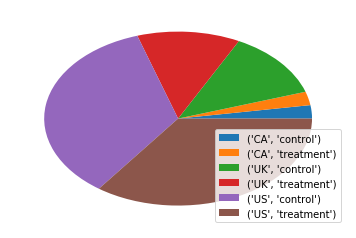

In [58]:
plt.pie(ge_cnt);
plt.legend(ge_cnt.index);

**Final conclusion:**

1. General results are similar to results above with out significant interaction between page and countryies (all slopes):
 - p-values more than Type I error rate ($\alpha = 0.05$)
 - z-score higher than $Z_{\alpha}$ = -1.645 <br>
This allow us fail to reject initial $H_0$ hypothesys from section ToDo 2.1<br>
2. Compare to baseline contry 'CA' other have higher convertion rate (but not significant):
 - slope UK = 1.051944
 - slope US = 1.041599
3. Addition additional variables showed that there is no interaction between page and country columns.
4. Detailed analysys showed that main part of responces - US, and smalles is CA. Therefore it's good to increase number of respondents from CA (could be % from total population)
5. A soon as no country impact on convertion rate other factors (i.e. age, different target groups) good to add for next testing.
6. For this test recomendation not to start new web page now, continue testing with new factors to make more specific decision. 

<a id='finalcheck'></a>
## Final Check!

Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!

<a id='submission'></a>
## Submission
You may either submit your notebook through the "SUBMIT PROJECT" button at the bottom of this workspace, or you may work from your local machine and submit on  the last page of this project lesson.  

1. Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).


2. Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.


3. Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [59]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0